In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## cuda 있으면 사용하기

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print("Current device is [", device, ']')

Current device is [ cuda ]


In [3]:
# 파라미터
batch_size = 50
learning_rate = 0.0001
epoch_num = 15

In [4]:
## 데이터 불러오기

train_data = datasets.MNIST(root = './data/MNIST',
                           train = True,
                           download = True, # 다운은 처음에만 해라.
                           transform = transforms.ToTensor())

test_data = datasets.MNIST(root = './data/MNIST',
                           train = False,
                           transform = transforms.ToTensor())

print('Number of training data :',len(train_data))
print('Number of test data :',len(test_data))

Number of training data : 60000
Number of test data : 10000


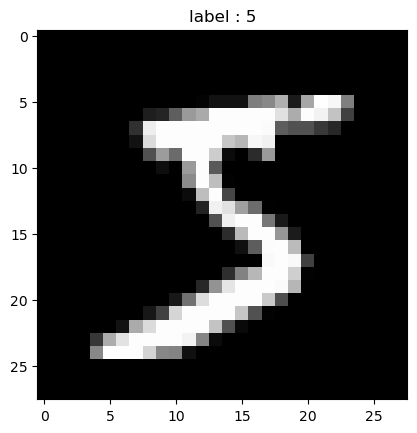

In [5]:
#import os    
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

image, label = train_data[0] 
# torch MNIST 데이터는 라벨과 이미지 두 개로 되있어서 두 개로 받아야한다.

# torch MNIST 데이터는 이미 3차원(채널포함) 데이터라서 squeeze를 사용해 채널을 제거해서 그려야한다.
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title('label : %s' % label)
plt.show()

- keras 채널은 맨 뒤 => [28, 28, 1]
- torch 채널은 맨 앞 => [1, 28, 28]

### 배치 구성

In [6]:
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                          batch_size = batch_size,
                                          shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                          batch_size = batch_size,
                                          shuffle = True)

first_batch = train_loader.__iter__().__next__() # 배치 (50개) 중 첫번 째를 가져와라

## 출력 포멧

In [7]:
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('-'*15, '-'*25, '-'*25))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))

print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))

print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[0])), first_batch[1].shape))

name            | type                      | size
--------------- | ------------------------- | -------------------------
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


- 15s : 15칸을 확보해라 15개가 안되면 띄어 쓰기해라
- < : 왼쪽정렬

- 60000만개 데이터가 50배치니까 1200개 묶음이다.

- 첫번째 배치의 [0]은 픽셀 데이터를 의미 : [개수, 채널, 픽셀, 픽셀]

- 첫번째 배치의 [1]은 라벨을 의미 :  50개씩 묶었으니 50개다

## 클래스로 정의해보자

In [8]:
class CNN(nn.Module):
    # 컨벌루션 2개로
    def __init__(self):
        super(CNN, self).__init__() # super를 사용해서 모듈을 상속받자
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding='same') 
                            # 입력채널의 수, 32개 채널로 출력, 커널사이즈 : 3x3, stride =1, 패딩 그대로
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding='same')
                            # 위에서 32입력, 64개 확대 출력, 커널사이즈 : 3x3, stride =1, 패딩 그대로
        self.dropout = nn.Dropout2d(0.25) # 0.25 비율만큼은 버리자
        
        # fullyconnected의 입출력을 정해줘야한다. (최종 픽셀 * 최종 채널)
        # 28 -> 풀링 2 => 14 -> 풀링 2 => 7  ====> 최종 픽셀은 7x7 로 나온다.
        # 마지막 레이어에서 채널의 output => 64 ====> 최종 채널은 64 로 나온다.

        self.fc1 = nn.Linear(3136, 1000) # 7 * 7 * 64 = 3136
        self.fc2 = nn.Linear(1000, 10)
        
    def forward(self, x):
        x = self.conv1(x) # 레이어
        x = F.relu(x) # 활성화 
        x = F.max_pool2d(x, 2) # 풀링 (풀링레이어는 가중치 없다!)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = F.relu(x)  # 은닉층?
        x = self.fc2(x)
        
        output = F.log_softmax(x, dim=1)
        
        return output

In [9]:
## 모델, loss, optimizer 선언

model = CNN().to(device)# GPU or CPU 작동
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [10]:
## 학습 시키자
model.train() # 이때 학습이 되는게 아니다. 학습 준비가 끝났다? 라고 생각하면 된다.
        # 학습모드로 전환이라 생각하자
i = 1
for epoch in range(epoch_num): # 15번 
    for data, target in train_loader: # 12000개
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward() # loss를 가지고 역전파 시켜라
        optimizer.step() # 가중치를 업데이트 해라
        
        if i % 1000 == 0:
            print('Train step : {}\tLoss : {:.3f}'.format(i, loss.item()))
        i += 1

Train step : 1000	Loss : 0.200
Train step : 2000	Loss : 0.069
Train step : 3000	Loss : 0.132
Train step : 4000	Loss : 0.050
Train step : 5000	Loss : 0.053
Train step : 6000	Loss : 0.299
Train step : 7000	Loss : 0.011
Train step : 8000	Loss : 0.006
Train step : 9000	Loss : 0.013
Train step : 10000	Loss : 0.008
Train step : 11000	Loss : 0.008
Train step : 12000	Loss : 0.007
Train step : 13000	Loss : 0.020
Train step : 14000	Loss : 0.084
Train step : 15000	Loss : 0.029
Train step : 16000	Loss : 0.000
Train step : 17000	Loss : 0.014
Train step : 18000	Loss : 0.009


## 왜 18번 이 출력되지?????????

In [17]:
## 학습 잘됬나 평가...

model.eval() # 평가 모드로 변환

correct = 0

for data, target in test_loader:
    #data, target = Variable(data, volatile=True), Variable(target)
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum() # eq는 같냐? 판단
    
print('Accuracy of Test set : {:.2f}%'.format(100. * correct / len(test_loader.dataset)))

Accuracy of Test set : 99.13%
